# EDA

Before moving on to modeling, here's some valuable exploration to help better understand the data we're working with. The charts and manipulations help us build a general framework for our modeling approach moving forward

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

globe = pd.read_pickle('sample.pkl')
subset = pd.read_pickle('least_vars.pkl')

## Gloabl Sea Surface Temp

In [2]:
globe['timestamp'] = pd.to_datetime(globe[['year', 'month', 'day']])
newfoundland = globe[(globe['latitude'] == 46.4) & (globe['longitude'] == -48.4)].sort_values('timestamp', ascending=True)

### Global vs Single Locaiton Trends

To illustrate the variance in sea surface temperature across the globe versus within a single set of coordinates, notice the thickness of the respective lines.

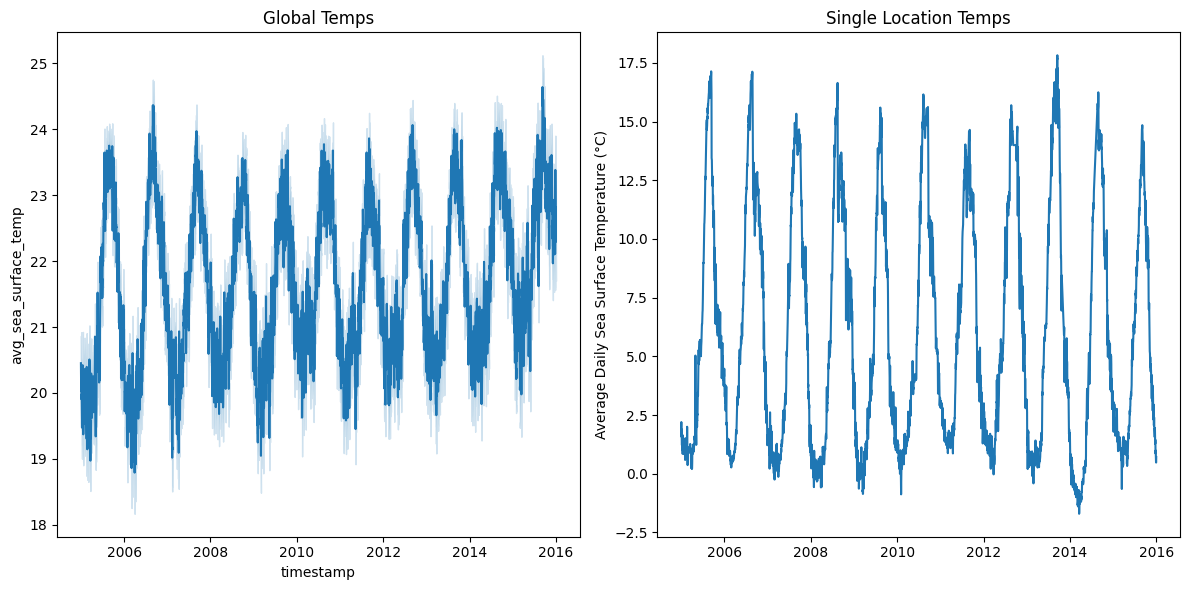

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(data=globe, x='timestamp', y='avg_sea_surface_temp', ax=ax[0])
ax[0].set_title('Global Temps')

plt.ylabel('Average Daily Sea Surface Temperature (°C)')
plt.xlabel('')

sns.lineplot(data=newfoundland, x='timestamp', y='avg_sea_surface_temp', ax=ax[1])
ax[1].set_title('Single Location Temps')

plt.ylabel('Average Daily Sea Surface Temperature (°C)')
plt.xlabel('')

plt.tight_layout()
plt.show()

#### Potential Predictors of Sea Surface Temperature

We want to consider using additional variables outside of a sequence of the predictor, so lets look at a heatmap

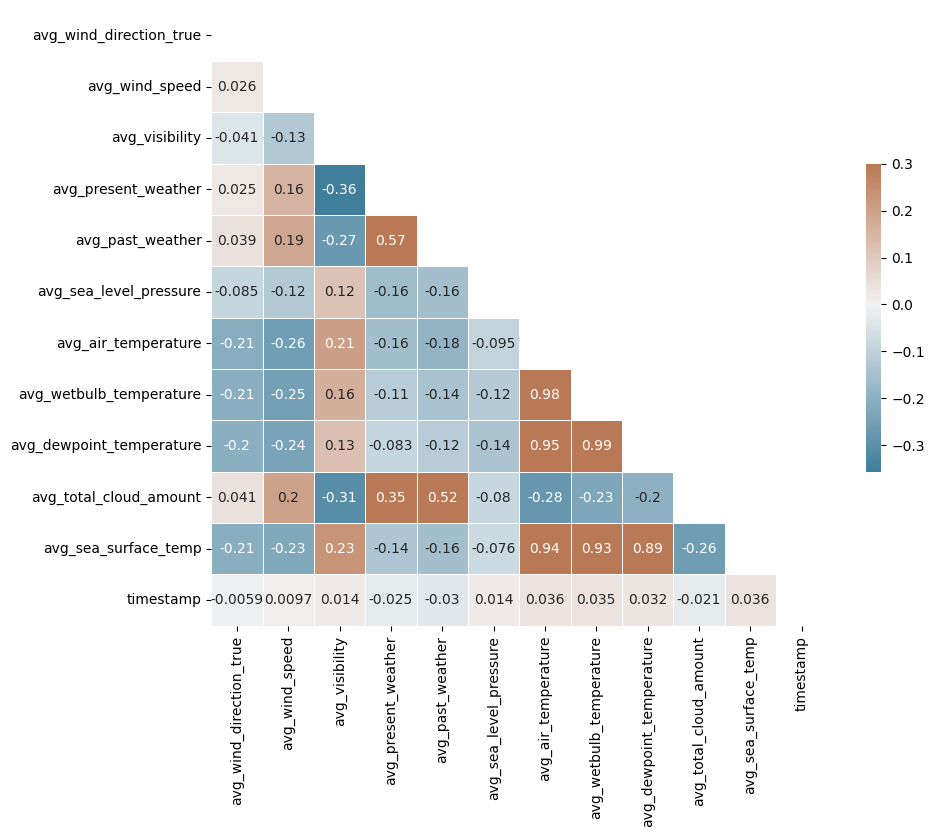

In [4]:
# These parameters for the sns.heatmap are taken from sns.heatmap documentation. It creates a heatmap that very much resembles the corrplot() from R
corr = globe.drop(columns=['year', 'month', 'day', 'longitude', 'latitude']).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 30, as_cmap=True)

plt.figure(figsize=(10, 8))  # Adjust the size of the figure as per your requirement
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True,
            vmax=.3, center=0, square=True,
            linewidths=.5, cbar_kws={'shrink': .5})
plt.show()

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(globe.drop(columns=['year', 'month', 'day', 'latitude', 'longitude', 'timestamp']))
scaled = pd.DataFrame(scaler.transform(globe.drop(columns=['year', 'month', 'day', 'latitude', 'longitude', 'timestamp'])), columns=globe.drop(columns=['year', 'month', 'day', 'latitude', 'longitude', 'timestamp']).columns)
scaled['timestamp'] = globe['timestamp']

newfoundland_scaled = scaled[(globe['latitude'] == 46.4) & (globe['longitude'] == -48.4)].sort_values('timestamp', ascending=True)

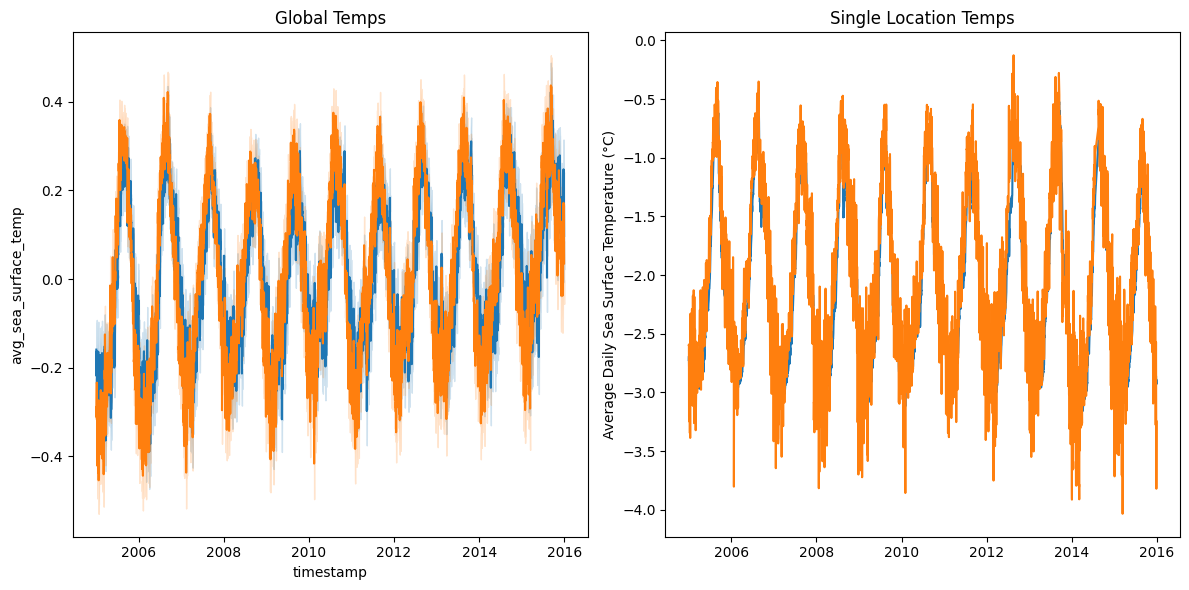

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(data=scaled, x='timestamp', y='avg_sea_surface_temp', ax=ax[0])
sns.lineplot(data=scaled, x='timestamp', y='avg_air_temperature', ax=ax[0])
ax[0].set_title('Global Temps')

plt.ylabel('Average Daily Sea Surface Temperature (°C)')
plt.xlabel('')

sns.lineplot(data=newfoundland_scaled, x='timestamp', y='avg_sea_surface_temp', ax=ax[1])
sns.lineplot(data=newfoundland_scaled, x='timestamp', y='avg_air_temperature', ax=ax[1])
ax[1].set_title('Single Location Temps')

plt.ylabel('Average Daily Sea Surface Temperature (°C)')
plt.xlabel('')

plt.tight_layout()
plt.show()

You can see globally that the blue (sea temp) is preceeded by orange (air temp), this along with the heatmap would suggest it is a good covariate

### The Problem

Ultimately, it will be useful to model individual locations, rather than the global average. However, there are missing values throughout timestamps in certain locations

In [7]:
globe['Lat, Long'] = globe['latitude'].astype(str) + ', ' + globe['longitude'].astype(str)

In [8]:
example = globe[(globe['Lat, Long'] == '53.8, -3.5') | (globe['Lat, Long'] == '54.4, 11.1')]

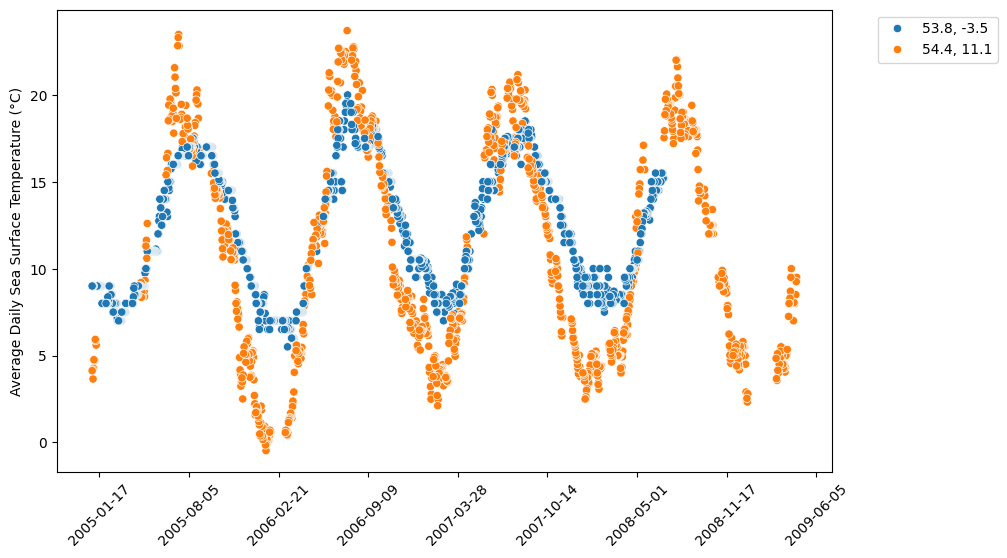

In [9]:
plt.figure(figsize=(10, 6))  # Adjust size if needed

sns.scatterplot(data=example[:-1], y='avg_sea_surface_temp', x='timestamp', hue='Lat, Long')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Adjust number of xticks
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.ylabel('Average Daily Sea Surface Temperature (°C)')
plt.xlabel('')

plt.show()

## Manipulations

ICOADS unfortunately does not impute the null rows with a timestamp for data that wasn't recorded. We'll need to construct the timestamps ourselves and join back what data we have. The Ultimate goal is to interpolate the missing values (as these variables clearly follow a precise pattern). Additionally, we want to cut down the time window, as longer sequences will introduce vanishing gradient issues

In [10]:
subset['timestamp'] = pd.to_datetime(subset[['year', 'month', 'day']])
subset['lat, long'] = subset['latitude'].astype(str) + ', ' + subset['longitude'].astype(str)
subset.drop(columns=['avg_wetbulb_temperature'], inplace=True)

In [11]:
subset.head()

,year,month,day,latitude,longitude,avg_air_temperature,avg_sea_surface_temp,timestamp,"lat, long"
0,2005,1,31,28.8,-15.6,15.5,18.0,2005-01-31,"28.8, -15.6"
1,2005,1,31,23.8,-81.0,21.1,23.3,2005-01-31,"23.8, -81.0"
2,2005,1,31,-19.6,4.6,23.3,24.3,2005-01-31,"-19.6, 4.6"
3,2005,1,31,-11.7,174.9,27.6,30.0,2005-01-31,"-11.7, 174.9"
4,2005,1,31,44.5,-149.0,11.8,10.3,2005-01-31,"44.5, -149.0"


In [75]:
locations = subset[(subset['year'] == 2015) & subset['lat, long'].isin(['46.4, -48.4', '5.3, 115.1', '-37.8, 144.9', '36.5, -6.5'])]

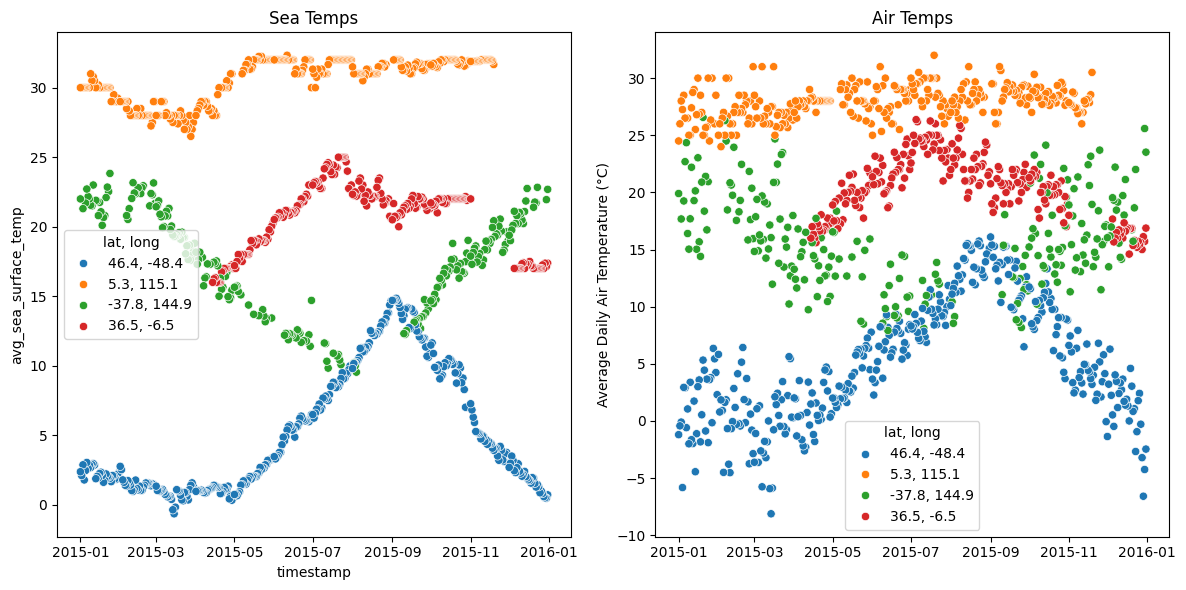

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(data=locations, x='timestamp', y='avg_sea_surface_temp', hue='lat, long', ax=ax[0])
ax[0].set_title('Sea Temps')

plt.ylabel('Average Daily Sea Surface Temperature (°C)')
plt.xlabel('')

sns.scatterplot(data=locations, x='timestamp', y='avg_air_temperature', hue='lat, long', ax=ax[1])
ax[1].set_title('Air Temps')

plt.ylabel('Average Daily Air Temperature (°C)')
plt.xlabel('')

plt.tight_layout()
plt.show()

In [77]:
def build(locs):
    master = pd.DataFrame(columns=['timestamp', 'lat, long'])
    
    for loc in locs:
        loc_df = pd.DataFrame(columns=['timestamp', 'lat, long'])
        loc_df['timestamp'] = pd.date_range(start='1-1-2015', end='12-31-2015', freq='D')
        loc_df['lat, long'] = loc
        master = pd.concat([master, loc_df])
    
    return master

locs = build(['46.4, -48.4', '5.3, 115.1', '-37.8, 144.9', '36.5, -6.5'])
final_df = locs.merge(locations.drop(columns=['year', 'month', 'day', 'latitude', 'longitude']), on=['timestamp', 'lat, long'], how='outer')

/var/folders/x3/42y9jxy964lg3yyk_9zhss280000gn/T/ipykernel_57843/3749615448.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  master = pd.concat([master, loc_df])


In [78]:
final_df

,timestamp,"lat, long",avg_air_temperature,avg_sea_surface_temp
0,2015-01-01,"-37.8, 144.9",19.900000,22.000000
1,2015-01-01,"36.5, -6.5",NaN,NaN
2,2015-01-01,"46.4, -48.4",-1.200000,2.375000
3,2015-01-01,"5.3, 115.1",24.500000,30.000000
4,2015-01-02,"-37.8, 144.9",NaN,NaN
...,...,...,...,...
1455,2015-12-30,"5.3, 115.1",NaN,NaN
1456,2015-12-31,"-37.8, 144.9",23.521429,22.688235
1457,2015-12-31,"36.5, -6.5",16.875000,17.375000
1458,2015-12-31,"46.4, -48.4",-2.462500,0.712500


In [79]:
loc1 = final_df[final_df['lat, long'] == '46.4, -48.4']     # already full
loc2 = final_df[final_df['lat, long'] == '5.3, 115.1']      # missing 59   
loc3 = final_df[final_df['lat, long'] == '-37.8, 144.9']    # missing 134
loc4 = final_df[final_df['lat, long'] == '36.5, -6.5']      # missing 136 (and at beginning, need to inverse)

In [80]:
def interp(df):
    df['sea_interp'] = df['avg_sea_surface_temp'].interpolate(method='polynomial', order=1)
    df['air_interp'] = df['avg_air_temperature'].interpolate(method='polynomial', order=1)

    df['full_sea'] = df['sea_interp'].fillna(method='bfill').fillna(method='ffill')
    df['full_air'] = df['air_interp'].fillna(method='bfill').fillna(method='ffill')
    
    return df

In [ ]:
locations = [loc1, loc2, loc3, loc4]

data = pd.DataFrame(columns=final_df.columns)
data['sea_interp'] = np.nan
data['air_interp'] = np.nan

for location in locations:
    location = interp(location)
    data = pd.concat([data, location])

In [108]:
data

,timestamp,"lat, long",avg_air_temperature,avg_sea_surface_temp,sea_interp,air_interp,full_sea,full_air
2,2015-01-01,"46.4, -48.4",-1.200000,2.375000,2.375000,-1.200000,2.375000,-1.200000
6,2015-01-02,"46.4, -48.4",-0.428571,2.100000,2.100000,-0.428571,2.100000,-0.428571
10,2015-01-03,"46.4, -48.4",-0.100000,2.871429,2.871429,-0.100000,2.871429,-0.100000
14,2015-01-04,"46.4, -48.4",-5.828571,1.785714,1.785714,-5.828571,1.785714,-5.828571
18,2015-01-05,"46.4, -48.4",2.937500,2.462500,2.462500,2.937500,2.462500,2.937500
...,...,...,...,...,...,...,...,...
1441,2015-12-27,"36.5, -6.5",15.625000,17.250000,17.250000,15.625000,17.250000,15.625000
1445,2015-12-28,"36.5, -6.5",15.000000,17.000000,17.000000,15.000000,17.000000,15.000000
1449,2015-12-29,"36.5, -6.5",16.125000,17.375000,17.375000,16.125000,17.375000,16.125000
1453,2015-12-30,"36.5, -6.5",15.714286,17.142857,17.142857,15.714286,17.142857,15.714286


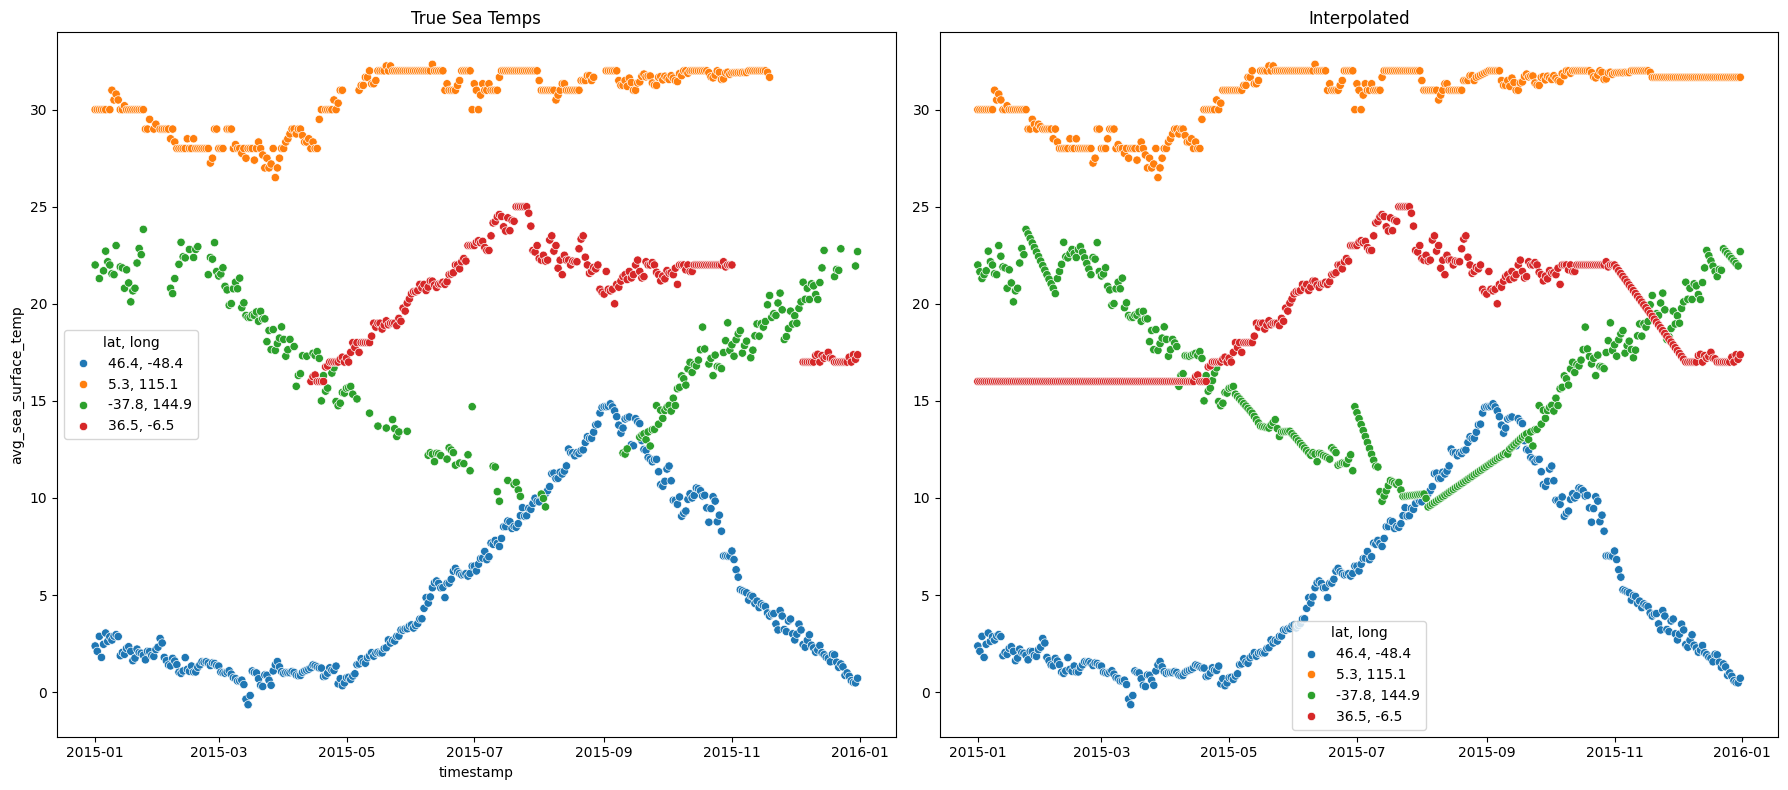

In [130]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

sns.scatterplot(data=data, x='timestamp', y='avg_sea_surface_temp', hue='lat, long', ax=ax[0])
ax[0].set_title('True Sea Temps')

plt.ylabel('')
plt.xlabel('')

sns.scatterplot(data=data, x='timestamp', y='full_sea', hue='lat, long', ax=ax[1])
ax[1].set_title('Interpolated')

plt.ylabel('')
plt.xlabel('')

plt.tight_layout()
plt.show()

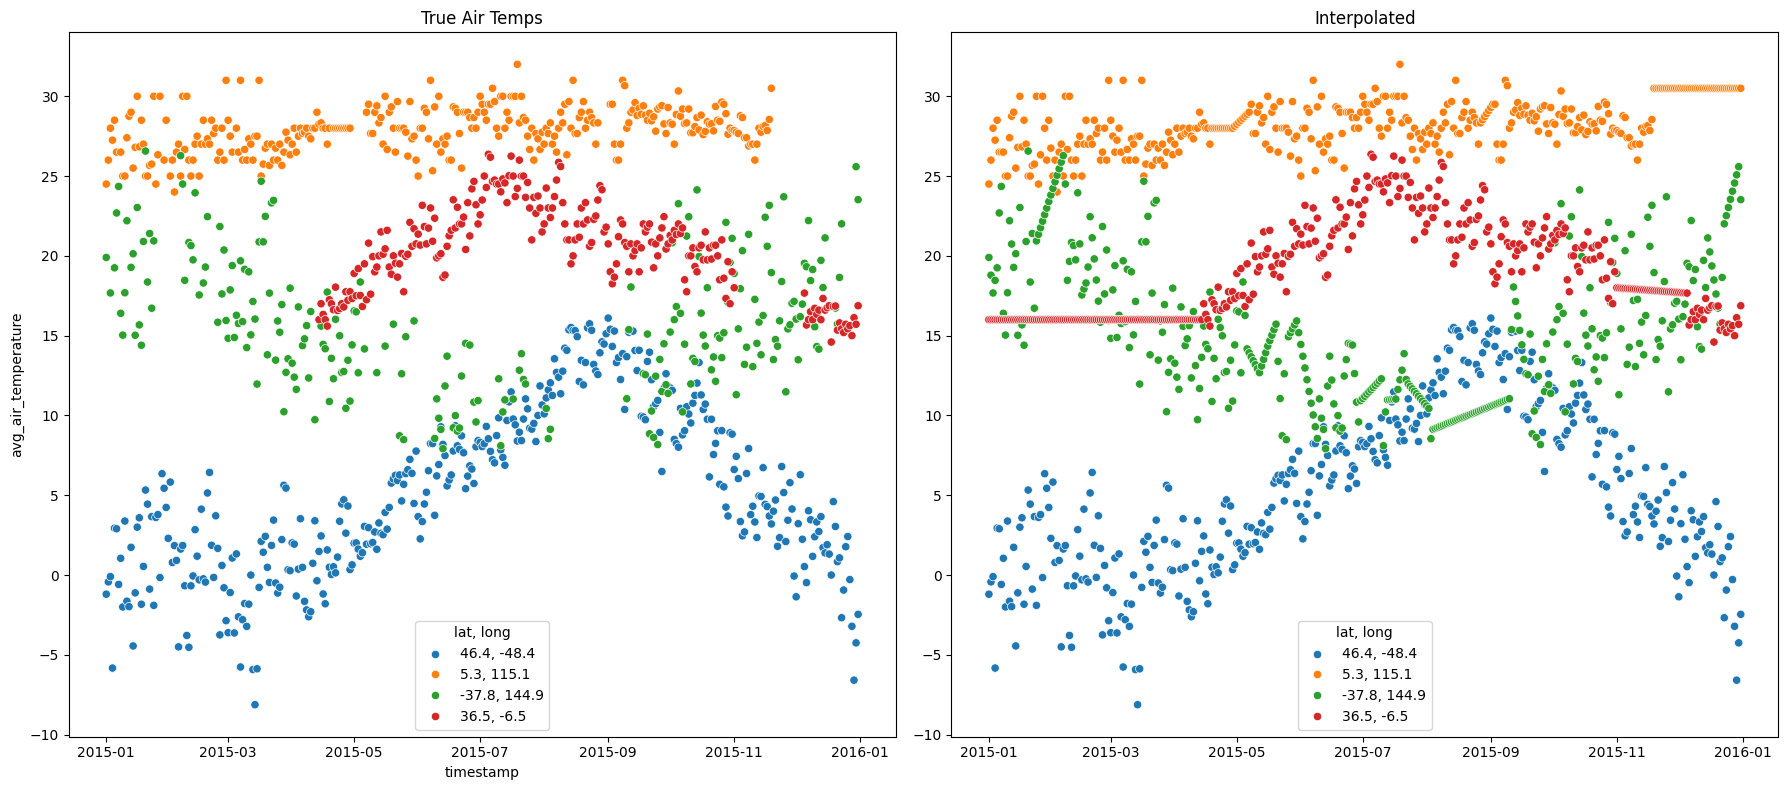

In [131]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

sns.scatterplot(data=data, x='timestamp', y='avg_air_temperature', hue='lat, long', ax=ax[0])
ax[0].set_title('True Air Temps')

plt.ylabel('')
plt.xlabel('')

sns.scatterplot(data=data, x='timestamp', y='full_air', hue='lat, long', ax=ax[1])
ax[1].set_title('Interpolated')

plt.ylabel('')
plt.xlabel('')

plt.tight_layout()
plt.show()